<a href="https://colab.research.google.com/github/JumanaKhrais/Transformer-Based-Deep-Learning-Models-for-Sarcasm-Detection-with-an-Imbalanced-Dataset./blob/main/sequentialModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deep learning models**
 
*  LSTM
*  BiLSTM
*  BiGRU


#Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D,Flatten,Bidirectional,GRU, Conv1D,SpatialDropout1D,MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import metrics 


**Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #this line to have the ability to read from and load to drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Reading Dataset + Handling Null Values**


In [ ]:
# Reading the dataset
pathT = "drive/MyDrive/TrainEnglish.csv"
train  = pd.read_csv(pathT)

In [ ]:
data = train[['tweet', 'sarcastic']].copy()


In [ ]:
data.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)

In [ ]:
tweets = data['tweet']
lables = data['sarcastic']

#Data Analysis and preprocessing

**The data is Imbalanced**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


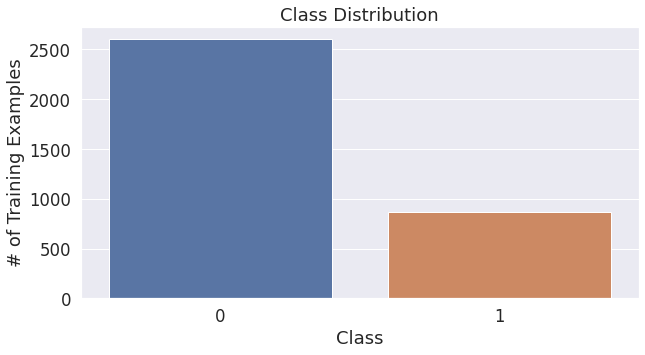

In [ ]:
sns.countplot(data['sarcastic'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('# of Training Examples')
plt.show()

In [ ]:
# Data is imbalanced

**Checking sequences lengths distribution**

In [ ]:
lengths = []
from tensorflow.keras.preprocessing.text import text_to_word_sequence
for ex in tweets:
    tokens = text_to_word_sequence(ex,split=' ')
    lengths.append(len(tokens))

In [ ]:
print('   Min length: {:,} '.format(min(lengths)))
print('   Max length: {:,} '.format(max(lengths)))
print('Median length: {:,} '.format(int(np.median(lengths))))

   Min length: 1 
   Max length: 63 
Median length: 17 


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


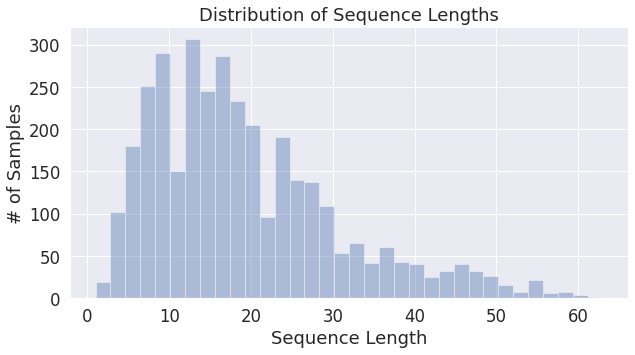

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)
sns.distplot(lengths, kde=False, rug=False)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('# of Samples')
plt.show()

**Reading Validation, Training, and Testing Datasets**

In [ ]:
pathT = "drive/MyDrive/train.csv"
trainD  = pd.read_csv(pathT)

In [ ]:
train = trainD['tweet']
trainL = trainD['sarcastic']

In [ ]:
pathT = "drive/MyDrive/valid.csv"
validD = pd.read_csv(pathT)

In [ ]:
valid = validD['tweet']
validL = validD['sarcastic']

In [ ]:
testD= pd.read_csv("drive/MyDrive/TestEnglish.csv")

In [ ]:
test = testD['text']
testL = testD['sarcastic']

In [ ]:
train.shape

(2946,)

In [ ]:
valid.shape

(521,)

In [ ]:
test.shape

(1400,)

#Tokenization

In [ ]:
maxlength = 67 #Based on the results above max length is choosen 
embeddingDim = 32 
vocabSize = 20000
truncating_type = 'post'
padding_type='post'
#Defining tokenizer
tokenizer = Tokenizer(num_words=vocabSize)
tokenizer.fit_on_texts(train) #Updates internal vocabulary based on a list of texts
#tokenizing data
Tokens_train = tokenizer.texts_to_sequences(train)
Tokens_test = tokenizer.texts_to_sequences(test) #transforms each text in texts to a sequence of integers
Tokens_validation = tokenizer.texts_to_sequences(valid)
#padding data into maximum length 
Tokens_train = pad_sequences(Tokens_train,  maxlen=maxlength,padding=padding_type,truncating=truncating_type)
Tokens_test = pad_sequences(Tokens_test, maxlen=maxlength,padding=padding_type,truncating=truncating_type)
Tokens_validation = pad_sequences(Tokens_validation, maxlen=maxlength,padding=padding_type,truncating=truncating_type)

# 1.LSTM model

In [ ]:
#hyperparameter finetuning
dropout_rate = 0.5
lstmunits = 32
nepochs= 12
batchSize= 24

**Defining the model**

In [ ]:
lstm = Sequential()
lstm.add(Embedding(vocabSize, embeddingDim, input_length=maxlength)) 
lstm.add(LSTM(lstmunits))
lstm.add(Dropout(dropout_rate))
lstm.add(Dense(8,activation="relu"))
lstm.add(Dense(1, activation='sigmoid'))
lstm.summary()
#dr.malak : add more layer before the dense ..

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 67, 32)            640000    
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 264       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 648,593
Trainable params: 648,593
Non-trainable params: 0
_________________________________________________________________


**Defining callbacks**

In [ ]:
callbacks = [EarlyStopping(monitor='val_accuracy',min_delta=1e-4,patience=6,verbose=1),
             ModelCheckpoint(filepath='lstm_weights.h5',monitor='val_accuracy', mode='max', save_best_only=True,save_weights_only=True,verbose=1)]

**Compile and train**

In [ ]:
lstm.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
historylstm = lstm.fit(Tokens_train, trainL, batch_size=batchSize, validation_data=(Tokens_validation , validL), epochs=nepochs, callbacks=callbacks)

Epoch 1/12
120/123 [============================>.] - ETA: 0s - loss: 0.5837 - accuracy: 0.7583
Epoch 1: val_accuracy improved from -inf to 0.69866, saving model to lstm_weights.h5
123/123 [==============================] - 3s 11ms/step - loss: 0.5846 - accuracy: 0.7570 - val_loss: 0.6178 - val_accuracy: 0.6987
Epoch 2/12
122/123 [============================>.] - ETA: 0s - loss: 0.5595 - accuracy: 0.7596
Epoch 2: val_accuracy did not improve from 0.69866
123/123 [==============================] - 1s 7ms/step - loss: 0.5597 - accuracy: 0.7590 - val_loss: 0.6157 - val_accuracy: 0.6987
Epoch 3/12
123/123 [==============================] - ETA: 0s - loss: 0.5601 - accuracy: 0.7590
Epoch 3: val_accuracy did not improve from 0.69866
123/123 [==============================] - 1s 7ms/step - loss: 0.5601 - accuracy: 0.7590 - val_loss: 0.6183 - val_accuracy: 0.6987
Epoch 4/12
115/123 [===========================>..] - ETA: 0s - loss: 0.5583 - accuracy: 0.7569
Epoch 4: val_accuracy did not impro

In [ ]:
lstm.load_weights('lstm_weights.h5')
lstm.save('lstm')

**Testing**

In [ ]:
lstmpreds = [round(i[0]) for i in lstm.predict(Tokens_test)]

In [ ]:
from sklearn import metrics 
print(metrics.accuracy_score(testL, lstmpreds))
print(metrics.precision_score(testL, lstmpreds))
print(metrics.recall_score(testL,lstmpreds))
print(metrics.f1_score(testL,lstmpreds)) 

0.8571428571428571
0.0
0.0
0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 2.BiLSTM model

In [ ]:
#hyperparameter finetuning
dropout_rate = 0.2
lstmunits = 64
nepochs= 40
batchSize=512

**Defining The model**

In [ ]:
Bilstm = Sequential()
Bilstm.add(Embedding(vocabSize, embeddingDim, input_length=maxlength)) 
Bilstm.add(Bidirectional(LSTM(lstmunits)))
Bilstm.add(Dropout(dropout_rate))
Bilstm.add(Dense(1, activation='sigmoid'))
Bilstm.summary()

**Defining Callback**

In [ ]:
callbacks = [EarlyStopping(monitor='val_accuracy',min_delta=1e-4,patience=6,verbose=1),
             ModelCheckpoint(filepath='Bilstm_weights.h5',monitor='val_accuracy', mode='max', save_best_only=True,save_weights_only=True,verbose=1)]

**Model compilation and training**

In [ ]:
Bilstm.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
historybilstm = Bilstm.fit(Tokens_train, trainL, batch_size=batchSize, validation_data=(Tokens_validation , validL), epochs=nepochs, callbacks=callbacks)

4/6 [===================>..........] - ETA: 0s - loss: 0.6764 - accuracy: 0.7471 
Epoch 1: val_accuracy improved from -inf to 0.69866, saving model to Bilstm_weights.h5
6/6 [==============================] - 4s 171ms/step - loss: 0.6501 - accuracy: 0.7505 - val_loss: 0.6177 - val_accuracy: 0.6987
Epoch 2/40
4/6 [===================>..........] - ETA: 0s - loss: 0.5584 - accuracy: 0.7554
Epoch 2: val_accuracy did not improve from 0.69866
6/6 [==============================] - 0s 26ms/step - loss: 0.5513 - accuracy: 0.7590 - val_loss: 0.6175 - val_accuracy: 0.6987
Epoch 3/40
4/6 [===================>..........] - ETA: 0s - loss: 0.4860 - accuracy: 0.7661
Epoch 3: val_accuracy did not improve from 0.69866
6/6 [==============================] - 0s 25ms/step - loss: 0.4836 - accuracy: 0.7593 - val_loss: 0.6053 - val_accuracy: 0.6987
Epoch 4/40
5/6 [========================>.....] - ETA: 0s - loss: 0.3411 - accuracy: 0.8219
Epoch 4: val_accuracy did not improve from 0.69866
6/6 [============

In [ ]:
Bilstm.load_weights('Bilstm_weights.h5')
Bilstm.save('Bilstm')

INFO:tensorflow:Assets written to: Bilstm/assets


INFO:tensorflow:Assets written to: Bilstm/assets


**Testing**

In [ ]:
Bilstmpreds = [round(i[0]) for i in Bilstm.predict(Tokens_test)]

In [ ]:
from sklearn import metrics 
print(metrics.accuracy_score(testL, Bilstmpreds))
print(metrics.precision_score(testL, Bilstmpreds))
print(metrics.recall_score(testL, Bilstmpreds))
print(metrics.f1_score(testL, Bilstmpreds)) 

0.8571428571428571
0.0
0.0
0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#3.BiGRU model

In [ ]:
dropout_rate = 0.5
GRUUnits = 128
nepochs=40
batchSize=512

**Defining The model**

In [ ]:
Bigru = Sequential()
Bigru.add(Embedding(vocabSize, embeddingDim, input_length=maxlength)) 
Bigru.add(Bidirectional(GRU(GRUUnits)))
Bigru.add(Dropout(dropout_rate))
Bigru.add(Dense(1, activation='sigmoid'))
Bigru.summary()

**Defining Callback**

In [ ]:
callbacks = [EarlyStopping(monitor='val_accuracy',min_delta=1e-4,patience=6,verbose=1),
             ModelCheckpoint(filepath='Bigru_weights.h5',monitor='val_accuracy', mode='max', save_best_only=True,save_weights_only=True,verbose=1)]

**Model compilation and training**

In [ ]:
Bigru.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
historyBigru = Bigru.fit(Tokens_train, trainL, batch_size=batchSize, validation_data=(Tokens_validation ,validL), epochs=nepochs, callbacks=callbacks)

In [ ]:
Bigru.load_weights('Bigru_weights.h5')
Bigru.save('Bigru')

INFO:tensorflow:Assets written to: Bigru/assets


INFO:tensorflow:Assets written to: Bigru/assets


**Testing**

In [ ]:
Bigrupreds = [round(i[0]) for i in Bigru.predict(Tokens_test)]

In [ ]:
"""Bigrupreds = Bigru.predict(Tokens_test)"""

In [ ]:
from sklearn import metrics 
print(metrics.accuracy_score(testL, Bilstmpreds))
print(metrics.precision_score(testL, Bilstmpreds))
print(metrics.recall_score(testL, Bilstmpreds))
print(metrics.f1_score(testL, Bilstmpreds)) 